<b> Functions <b>

In [2]:
from qutip import *
import pylab as py
import numpy as np
import matplotlib.pyplot as plt



def heaviside(x):
    if x >= 0 :
        return 1
    if x < 0 :
        return 0
    
def nega(rho, subsys):
    
    #create mask which counts the number of possible subsystems
    x = [0 for i in rho.dims[0]]
   
    #assigns a 1 in the position of the subsystem for which we want to compute the negativity
    x[subsys] = 1
        
    #takes partial transpose with respect to subsys x
    rho_pt = partial_transpose(rho, x)
    
    #finds eivenvalues of pt matrix
    eig = rho_pt.eigenenergies()
    
    #finds abs value of the eigenvalues
    abs_eig = abs(eig)
    
    negat = 0 #initialize value of negativity
    
    #takes the difference 
    diff = (abs_eig - eig)
    
    
    #computes negativity
    for el in diff:
        negat += el

    
    return negat


def three_pi(rho):
    
    #determine pi_a
    N_a_b = nega(rho.ptrace([1,2]),0)
    
    N_a_c = nega(rho.ptrace([1,3]),0)
    
    N_a_bc = nega(rho.ptrace([1,2,3]), 0)
    
    pi_a = max(0,(N_a_bc)**2 - (N_a_b)**2 - (N_a_c)**2)
    
    
    #determine pi_b
    N_b_a = nega(rho.ptrace([1,2]),1)
    
    N_b_c = nega(rho.ptrace([1,3]),0)
    
    N_b_ac = nega(rho.ptrace([1,2,3]), 1)
    
    pi_b = max(0,(N_b_ac)**2 - (N_b_a)**2 - (N_b_c)**2)
    
    #determine pi_c
    N_c_a = nega(rho.ptrace([1,3]),1)
    
    N_c_b = nega(rho.ptrace([2,3]),0)
    
    N_c_ab = nega(rho.ptrace([1,2,3]), 2)
    
    pi_c = max(0,(N_c_ab)**2 - (N_c_a)**2 - (N_c_b)**2)
    
    return (pi_a + pi_b + pi_c)/3


def three_tangle(rho):
    
    #determine res_tangle
    C_a_b = concurrence(rho.ptrace([1,2]))
    
    C_a_c = concurrence(rho.ptrace([1,3]))
    
    C_a_bc = np.sqrt(2-2*( ((rho.ptrace([1]))**2).tr() ) )
    
    
    return C_a_bc**2 - C_a_b**2 - C_a_c**2

<b> Parameters <b>

In [12]:
# wc=10   #frequency of cavity photons
# wa=9.1  #frequency of qubits


# N = 3      # number of cavity fock states (N-1 photons inn the cavity)
# n_th_a = 0.0           # temperature in frequency units
# g = 0.05*wc # coupling strength


# ti = 0
# tf = 2
# steps = 1001
# t_list = np.linspace(ti,tf,steps) # vector of time steps


wc = 10**(9)*2*np.pi*4.343 # frequency of the cavity photons
wa = 10**(9)*2*np.pi*5.439  # transition frequency of the qubits


N = 2      # number of cavity fock states (N-1 photons inn the cavity)
n_th_a = 0.0           # temperature in frequency units
g = 10**(6)*2*np.pi*200 # coupling strength

# #short time settings
# ti = 0 #initial time
# tf = 10**(-10)*1.5 #final time
# steps = 1000 #number of steps
# t_list = np.linspace(ti,tf,steps) # vector of time steps

#long time settings
ti = 0 #initial time
tf = 10**(-9)*40 #final time
steps = 4000 #number of steps
t_list = np.linspace(ti,tf,steps) # vector of time steps

# time/steps = 10^-11/3000


# Numerical solution

# Averaged coupling

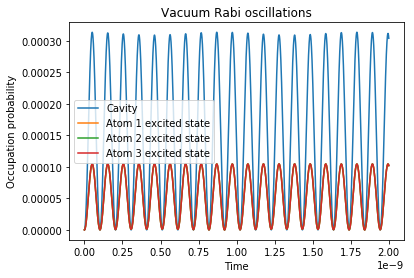

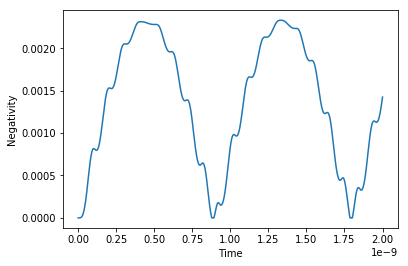

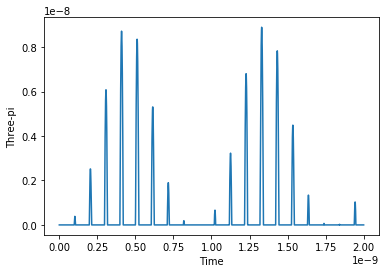

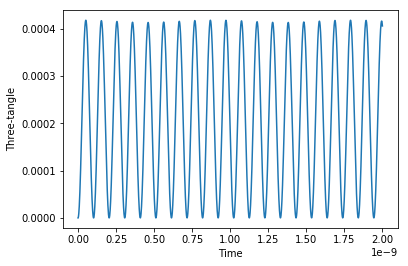

In [5]:


# intial state
psi0 = tensor(basis(N,0), basis(2,0), basis(2,0), basis(2,0))    # start with 0 excited atoms and 0 photons


# density matrix
rho0 = ket2dm(psi0)


# operators
a  = tensor(destroy(N), qeye(2), qeye(2), qeye(2)) #destroy cavity photon
sm1 = tensor(qeye(N), destroy(2),qeye(2), qeye(2)) #destroy atom1 excitation
sm2 = tensor(qeye(N), qeye(2),destroy(2), qeye(2)) #destroy atom2 excitation
sm3 = tensor(qeye(N), qeye(2), qeye(2), destroy(2)) #destroy atom3 excitation

#list of collapse operator (dissipation ops) for separate baths    
c_op_list = []



# Full Hamiltonian
    
H = wc*a.dag()*a + wa*sm1.dag()*sm1 + wa*sm2.dag()*sm2 + wa*sm3.dag()*sm3 + g*(a.dag()*sm1 + a*sm1.dag() + a.dag()*sm2 + a*sm2.dag() + a.dag()*sm3 + a*sm3.dag()) + g*(a*sm1 + a.dag()*sm1.dag() + a*sm2 + a.dag()*sm2.dag() + a*sm3 + a.dag()*sm3.dag())


# # Counter rotating Hamiltonian

# H = wc*a.dag()*a + wa*sm1.dag()*sm1 + wa*sm2.dag()*sm2 + wa*sm3.dag()*sm3 + g*(a*sm1 + a.dag()*sm1.dag() + a*sm2 + a.dag()*sm2.dag() + a*sm3 + a.dag()*sm3.dag())



#solve master equation
output = mesolve(H, rho0, t_list, c_op_list, [a.dag() * a, sm1.dag() * sm1, sm2.dag() * sm2 , sm3.dag() * sm3])  #stores expectation values of number of phontons, excitation of atom 1, 2, 3 

result = mesolve(H, rho0, t_list, c_op_list)  #stores density matrix operator changing in time



# plot excitation probabilities of photons and atoms
plt.plot(t_list, output.expect[0], label="Cavity")
plt.plot(t_list, output.expect[1], label="Atom 1 excited state")
plt.plot(t_list, output.expect[2], label="Atom 2 excited state")
plt.plot(t_list, output.expect[3], label="Atom 3 excited state")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.title('Vacuum Rabi oscillations');
plt.show()


neg = np.zeros(steps) #initialize vector of numerical time evolved negativity

res_pi = np.zeros(steps) #initialize vector of numerical time evolved three-pi

three_tan = np.zeros(steps) #initialize vector of numerical time evolved three-tangle


#computes the time evolution of the negativity
for i in range(steps):

    neg[i] = nega(result.states[i].ptrace([1,2,3]), 1) #find negativity
    
    res_pi[i] = three_pi(result.states[i]) #find three-pi
    
    three_tan[i] = three_tangle(result.states[i]) #find three-tangle

    
np.save('data/neg_avg_3q_num_an', neg)
np.save('data/tpi_avg_3q_num_an', res_pi)


#plot numerical negativity
plt.plot(t_list, neg)
plt.xlabel('Time')
plt.ylabel('Negativity')
plt.show()

#plot numerical three-pi
plt.plot(t_list, res_pi)
plt.xlabel('Time')
plt.ylabel('Three-pi')
plt.show()


#plot numerical three-tangle
plt.plot(t_list, three_tan)
plt.xlabel('Time')
plt.ylabel('Three-tangle')
plt.show()



# Dynamical coupling

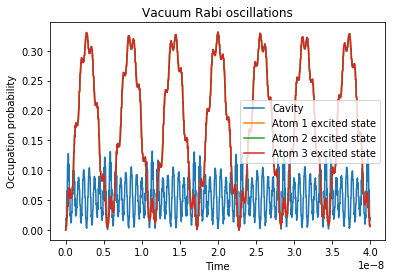

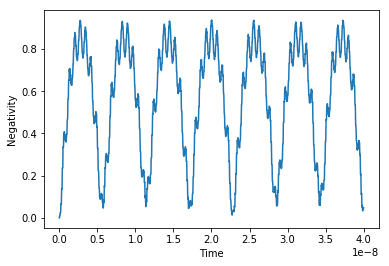

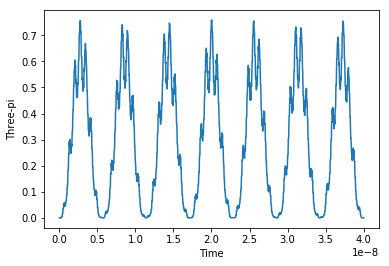

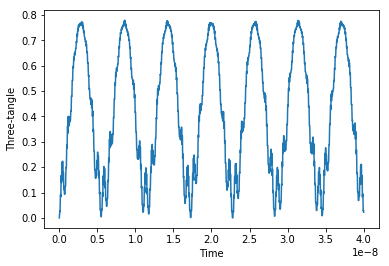

In [13]:
# #time settings
# ti = 0 #initial time
# tf = 10**(-9)*2 #final time
# steps = 5000 #number of steps
# t_list = np.linspace(ti,tf,steps) # vector of time steps

# intial state
psi0 = tensor(basis(N,0), basis(2,0), basis(2,0), basis(2,0))    # start with 0 excited atoms and 0 photons


# density matrix
rho0 = ket2dm(psi0)


# operators
a  = tensor(destroy(N), qeye(2), qeye(2), qeye(2)) #destroy cavity photon
sm1 = tensor(qeye(N), destroy(2),qeye(2), qeye(2)) #destroy atom1 excitation
sm2 = tensor(qeye(N), qeye(2),destroy(2), qeye(2)) #destroy atom2 excitation
sm3 = tensor(qeye(N), qeye(2), qeye(2), destroy(2)) #destroy atom3 excitation

#list of collapse operator (dissipation ops) for separate baths    
c_op_list = []




# high freq modulation
def H1_coeff(t,args):
    coeff = 2*g*heaviside(np.cos((2*wa)*t + 3/2*np.pi))
    return coeff

# # single switch
# def H1_coeff(t,args):
#     coeff = g*heaviside(t)
#     return coeff

H0 = wc*a.dag()*a + wa*sm1.dag()*sm1 + wa*sm2.dag()*sm2 + wa*sm3.dag()*sm3

H1 = (a.dag()*sm1 + a*sm1.dag() + a.dag()*sm2 + a*sm2.dag() + a*sm1 + a.dag()*sm1.dag() + a*sm2 + a.dag()*sm2.dag() + a.dag()*sm3 + a*sm3.dag() + a*sm3 + a.dag()*sm3.dag())


H = [H0,[H1,H1_coeff]]


#solve master equation
output = mesolve(H, rho0, t_list, c_op_list, [a.dag() * a, sm1.dag() * sm1, sm2.dag() * sm2 , sm3.dag() * sm3])  #stores expectation values of number of phontons, excitation of atom 1, 2, 3 

result = mesolve(H, rho0, t_list, c_op_list)  #stores density matrix operator changing in time



# plot excitation probabilities of photons and atoms
plt.plot(t_list, output.expect[0], label="Cavity")
plt.plot(t_list, output.expect[1], label="Atom 1 excited state")
plt.plot(t_list, output.expect[2], label="Atom 2 excited state")
plt.plot(t_list, output.expect[3], label="Atom 3 excited state")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Occupation probability')
plt.title('Vacuum Rabi oscillations');
plt.show()


neg_2 = np.zeros(steps) #initialize vector of numerical time evolved negativity

res_pi_2 = np.zeros(steps) #initialize vector of numerical time evolved three-pi

three_tan_2 = np.zeros(steps) #initialize vector of numerical time evolved three-tangle



#computes the time evolution of the negativity
for i in range(steps):

    neg_2[i] = nega(result.states[i].ptrace([1,2,3]), 1) #find negativity
    
    res_pi_2[i] = three_pi(result.states[i]) #find three-pi

    three_tan_2[i] = three_tangle(result.states[i]) #find three-tangle


np.save('data/neg_dyn_3q_num_an', neg_2)
np.save('data/tpi_dyn_3q_num_an', res_pi_2)

#plot numerical negativity
plt.plot(t_list, neg_2)
plt.xlabel('Time')
plt.ylabel('Negativity')
plt.show()

#plot numerical three-pi
plt.plot(t_list, res_pi_2)
plt.xlabel('Time')
plt.ylabel('Three-pi')
plt.show()


#plot numerical three-tangle
plt.plot(t_list, three_tan_2)
plt.xlabel('Time')
plt.ylabel('Three-tangle')
plt.show()





<b> Analytical solutions <b>

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


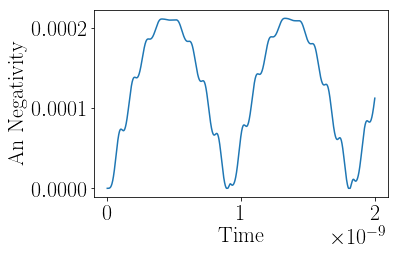

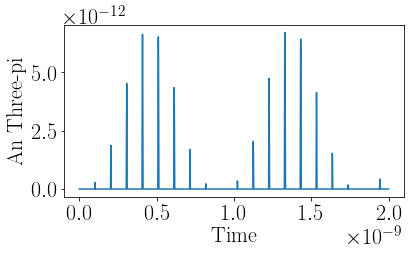

In [144]:
neg_an = np.zeros(steps) #initialize vector of analytical time evolved negativity

res_pi_an = np.zeros(steps) #initialize vector of analytical time evolved three-pi



cont = 0 #initialize counter




#computes the time evolution of the analytical negativity
for t in t_list:
    
    # states found analytically for the FULL Hamiltonian
    #psi0_an =  (1+2*(g/(wc+wa))**2*(complex(0,1)*(wc+wa)*t + (np.exp(-complex(0,1)*(wc+wa)*t))-1))*(tensor(basis(N,0), basis(2,0), basis(2,0), basis(2,0))) + g*(1/wc+wa)*(np.exp(-complex(0,1)*(wc+wa)*t)-1)*( tensor(basis(N,1), basis(2,1), basis(2,0), basis(2,0)) + tensor(basis(N,1), basis(2,0), basis(2,1), basis(2,0)) + tensor(basis(N,1), basis(2,0), basis(2,0), basis(2,1)) ) + (g**2)*(2/(wc+wa)*((2*wa)*(-np.exp(-complex(0,1)*(wc+wa)*t))+(wc+wa)*(np.exp(-complex(0,1)*(2*wa)*t)-1)+2*wa)/(2*wa*(2*wa-(wa+wc))))*( tensor(basis(N,0), basis(2,1), basis(2,1), basis(2,0)) + tensor(basis(N,0), basis(2,1), basis(2,0), basis(2,1)) + tensor(basis(N,0), basis(2,0), basis(2,1), basis(2,1))  )
    psi0_an = tensor(basis(N,0), basis(2,0), basis(2,0), basis(2,0) ) + g/(wc+wa)*(np.exp(-complex(0,1)*(wc+wa)*t) - 1)*(tensor(basis(N,1), basis(2,1), basis(2,0), basis(2,0) ) + tensor(basis(N,1), basis(2,0), basis(2,1), basis(2,0)) + tensor(basis(N,1), basis(2,0), basis(2,0), basis(2,1) ) ) + 3*(g**2)/(wc+wa)*(complex(0,1)*(wc+wa)*t + np.exp(-complex(0,1)*(wc+wa)*t) -1)/(wc+wa)*tensor(basis(N,0), basis(2,0), basis(2,0), basis(2,0) ) + (g**2)/(wa+wc)*(2*((2*wa)*(-np.exp(-complex(0,1)*(wc+wa)*t))+(wc+wa)*(np.exp(-complex(0,1)*(2*wa)*t)-1)+2*wa)/(2*wa*(2*wa-(wa+wc))))*(tensor(basis(N,0), basis(2,1), basis(2,1), basis(2,0) ) +tensor(basis(N,0), basis(2,0), basis(2,1), basis(2,1) )+tensor(basis(N,0), basis(2,1), basis(2,0), basis(2,1)) )
    psi_an = psi0_an.unit()
    
#     # states found analytically for the COUNTER-ROTATING hamiltonian
#     #psi0_an =  (1+2*(g/(wc+wa))**2*(complex(0,1)*(wc+wa)*t + (np.exp(-complex(0,1)*(wc+wa)*t))-1))*(tensor(basis(N,0), basis(2,0), basis(2,0), basis(2,0))) + g*(1/wc+wa)*(np.exp(-complex(0,1)*(wc+wa)*t)-1)*( tensor(basis(N,1), basis(2,1), basis(2,0), basis(2,0)) + tensor(basis(N,1), basis(2,0), basis(2,1), basis(2,0)) + tensor(basis(N,1), basis(2,0), basis(2,0), basis(2,1)) ) + (g**2)*(2/(wc+wa)*((2*wa)*(-np.exp(-complex(0,1)*(wc+wa)*t))+(wc+wa)*(np.exp(-complex(0,1)*(2*wa)*t)-1)+2*wa)/(2*wa*(2*wa-(wa+wc))))*( tensor(basis(N,0), basis(2,1), basis(2,1), basis(2,0)) + tensor(basis(N,0), basis(2,1), basis(2,0), basis(2,1)) + tensor(basis(N,0), basis(2,0), basis(2,1), basis(2,1))  )
#     psi0_an = tensor(basis(N,0), basis(2,0), basis(2,0), basis(2,0) ) + g/(wc+wa)*(np.exp(-complex(0,1)*(wc+wa)*t) - 1)*(tensor(basis(N,1), basis(2,1), basis(2,0), basis(2,0) ) + tensor(basis(N,1), basis(2,0), basis(2,1), basis(2,0)) + tensor(basis(N,1), basis(2,0), basis(2,0), basis(2,1) ) ) + 3*(g**2)/(wc+wa)*(complex(0,1)*(wc+wa)*t + np.exp(-complex(0,1)*(wc+wa)*t) -1)/(wc+wa)*tensor(basis(N,0), basis(2,0), basis(2,0), basis(2,0) ) 
#     psi_an = psi0_an.unit()
    
    #density matrix
    rho_an = ket2dm(psi_an)
    
    neg_an[cont] = nega(rho_an.ptrace([1,2,3]),1) #find negativity
    
    res_pi_an[cont] = three_pi(rho_an) #find three-pi
    
    
    cont += 1 # increase counter

np.save('data/neg_ana_3q_num_an', neg_an)
np.save('data/tpi_ana_3q_num_an', res_pi_an)
    
    
#plot analytical negativity
plt.plot(t_list, neg_an)
plt.xlabel('Time')
plt.ylabel('An Negativity')
plt.show()

#plot analytical three-pi
plt.plot(t_list, res_pi_an)
plt.xlabel('Time')
plt.ylabel('An Three-pi')
plt.show()





<b> Compare analytical and numerical results <b>

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


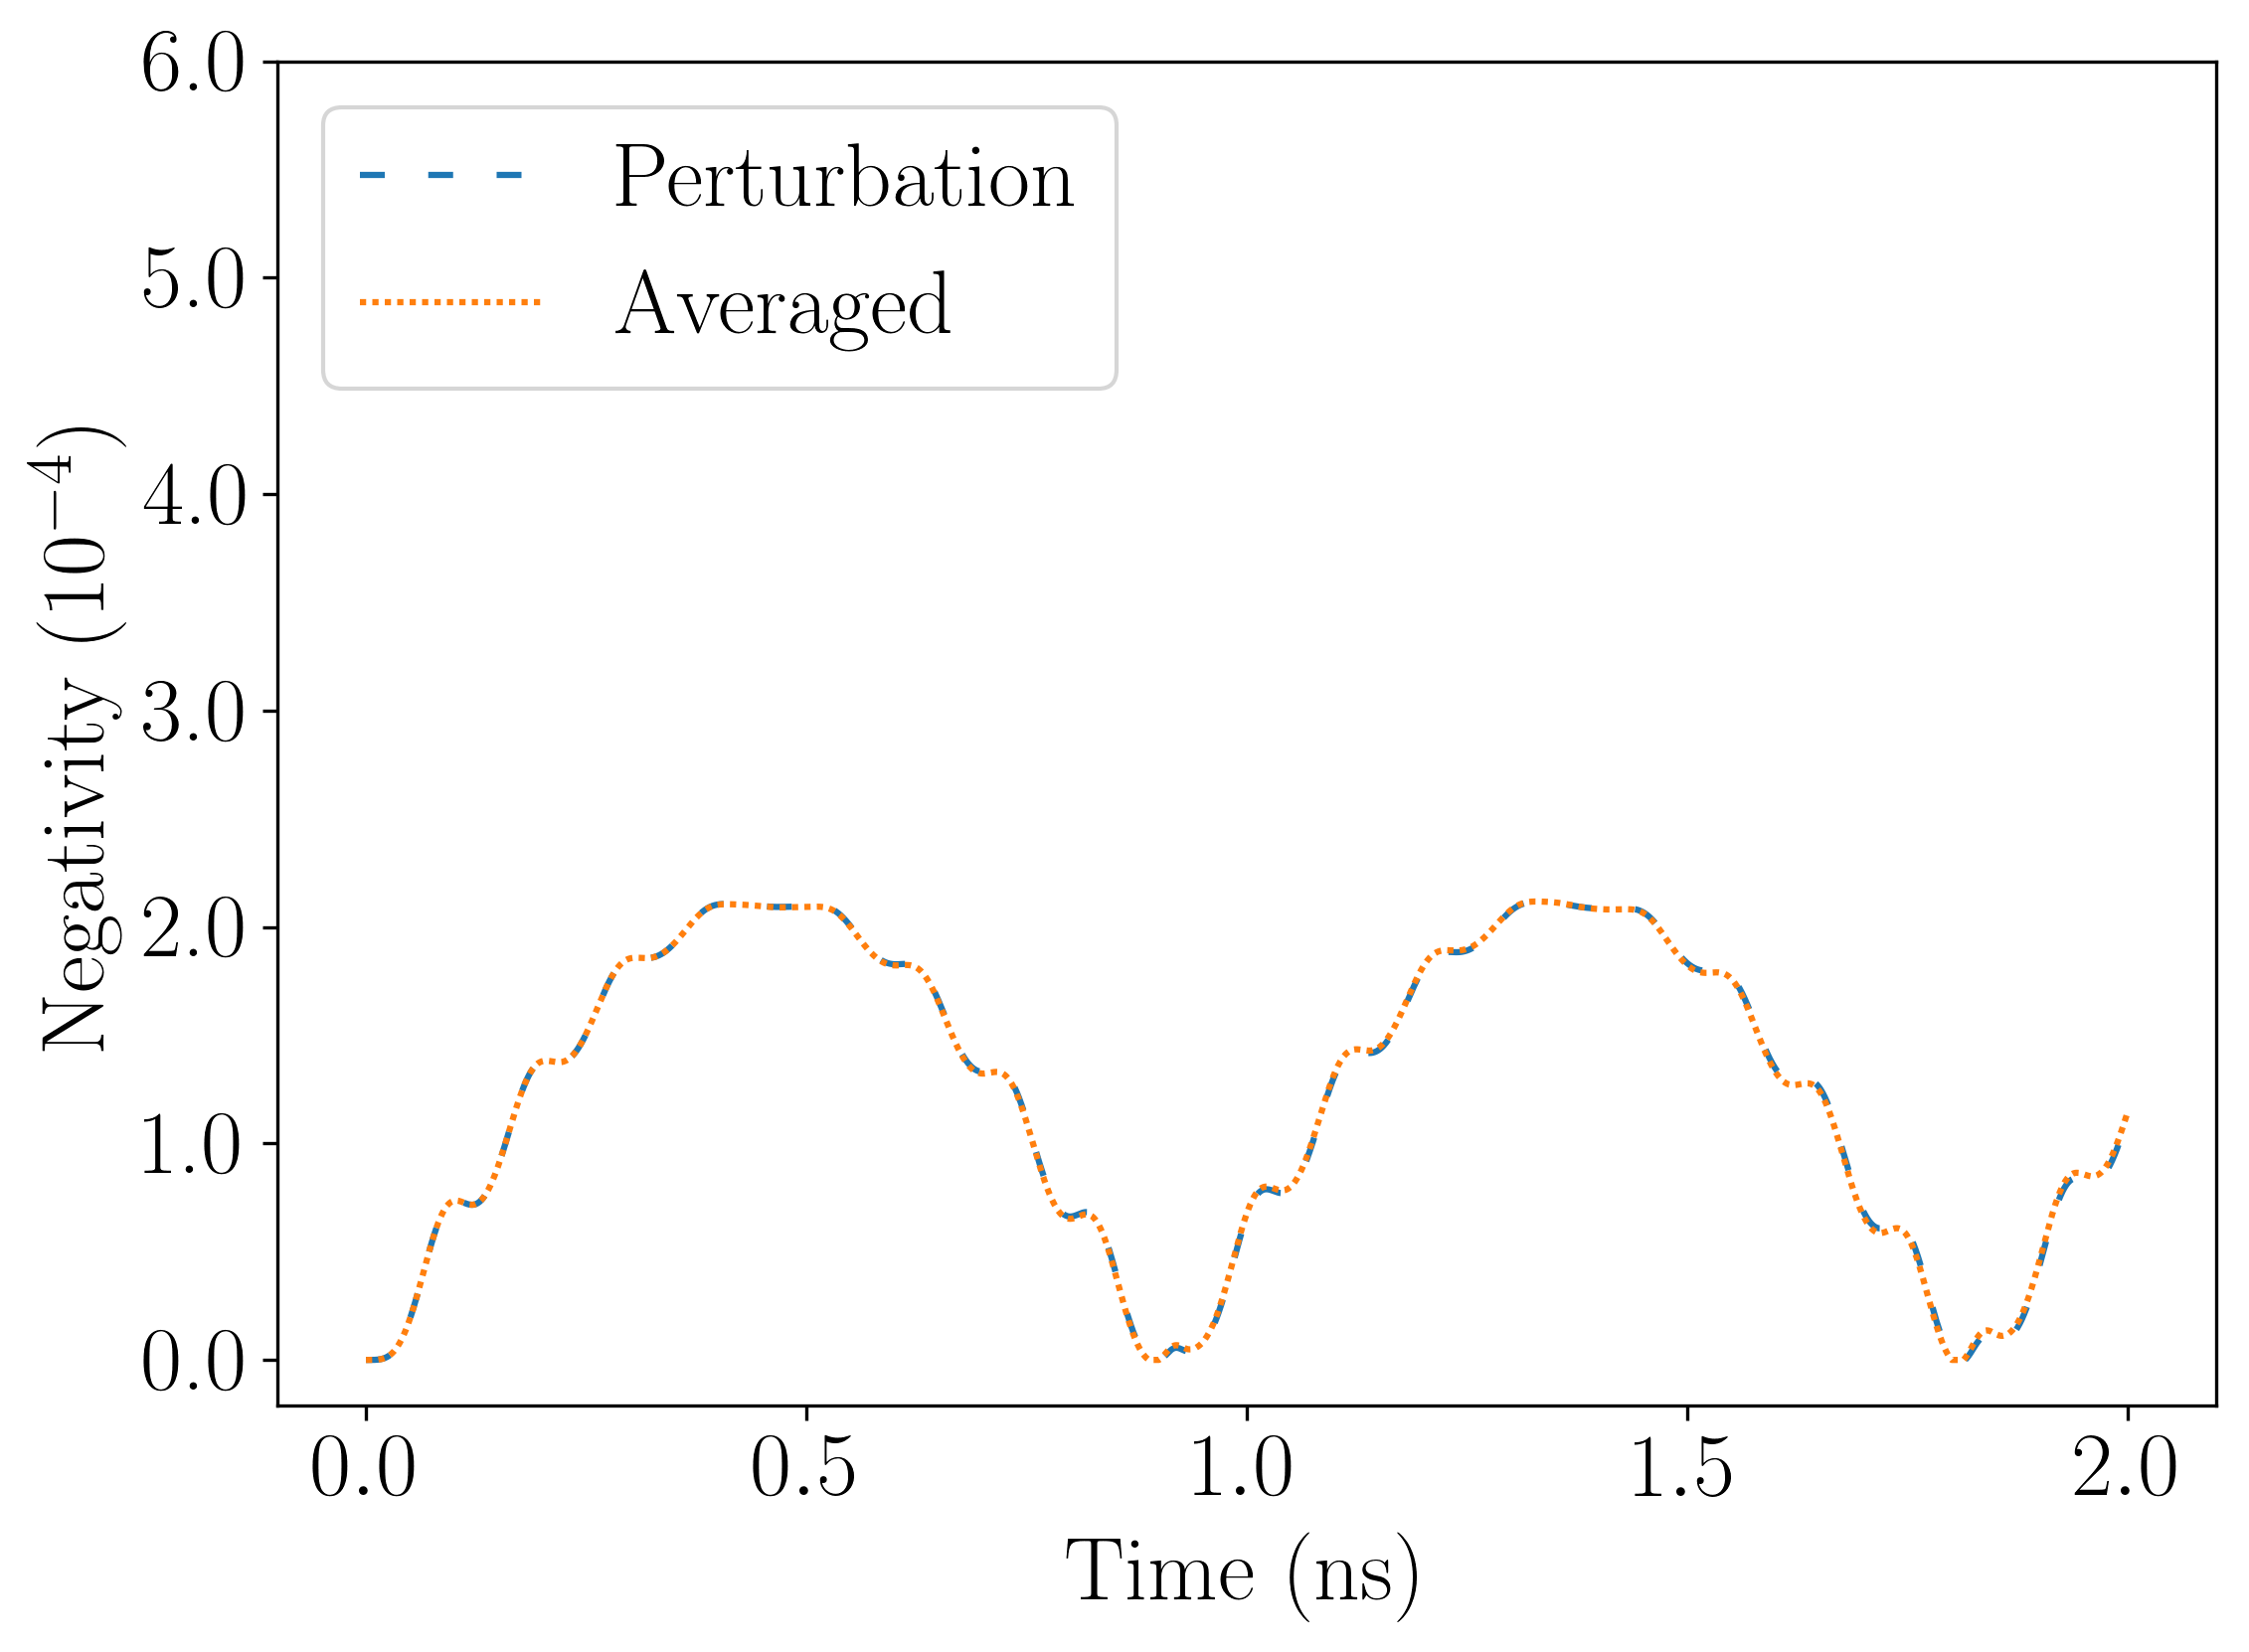

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


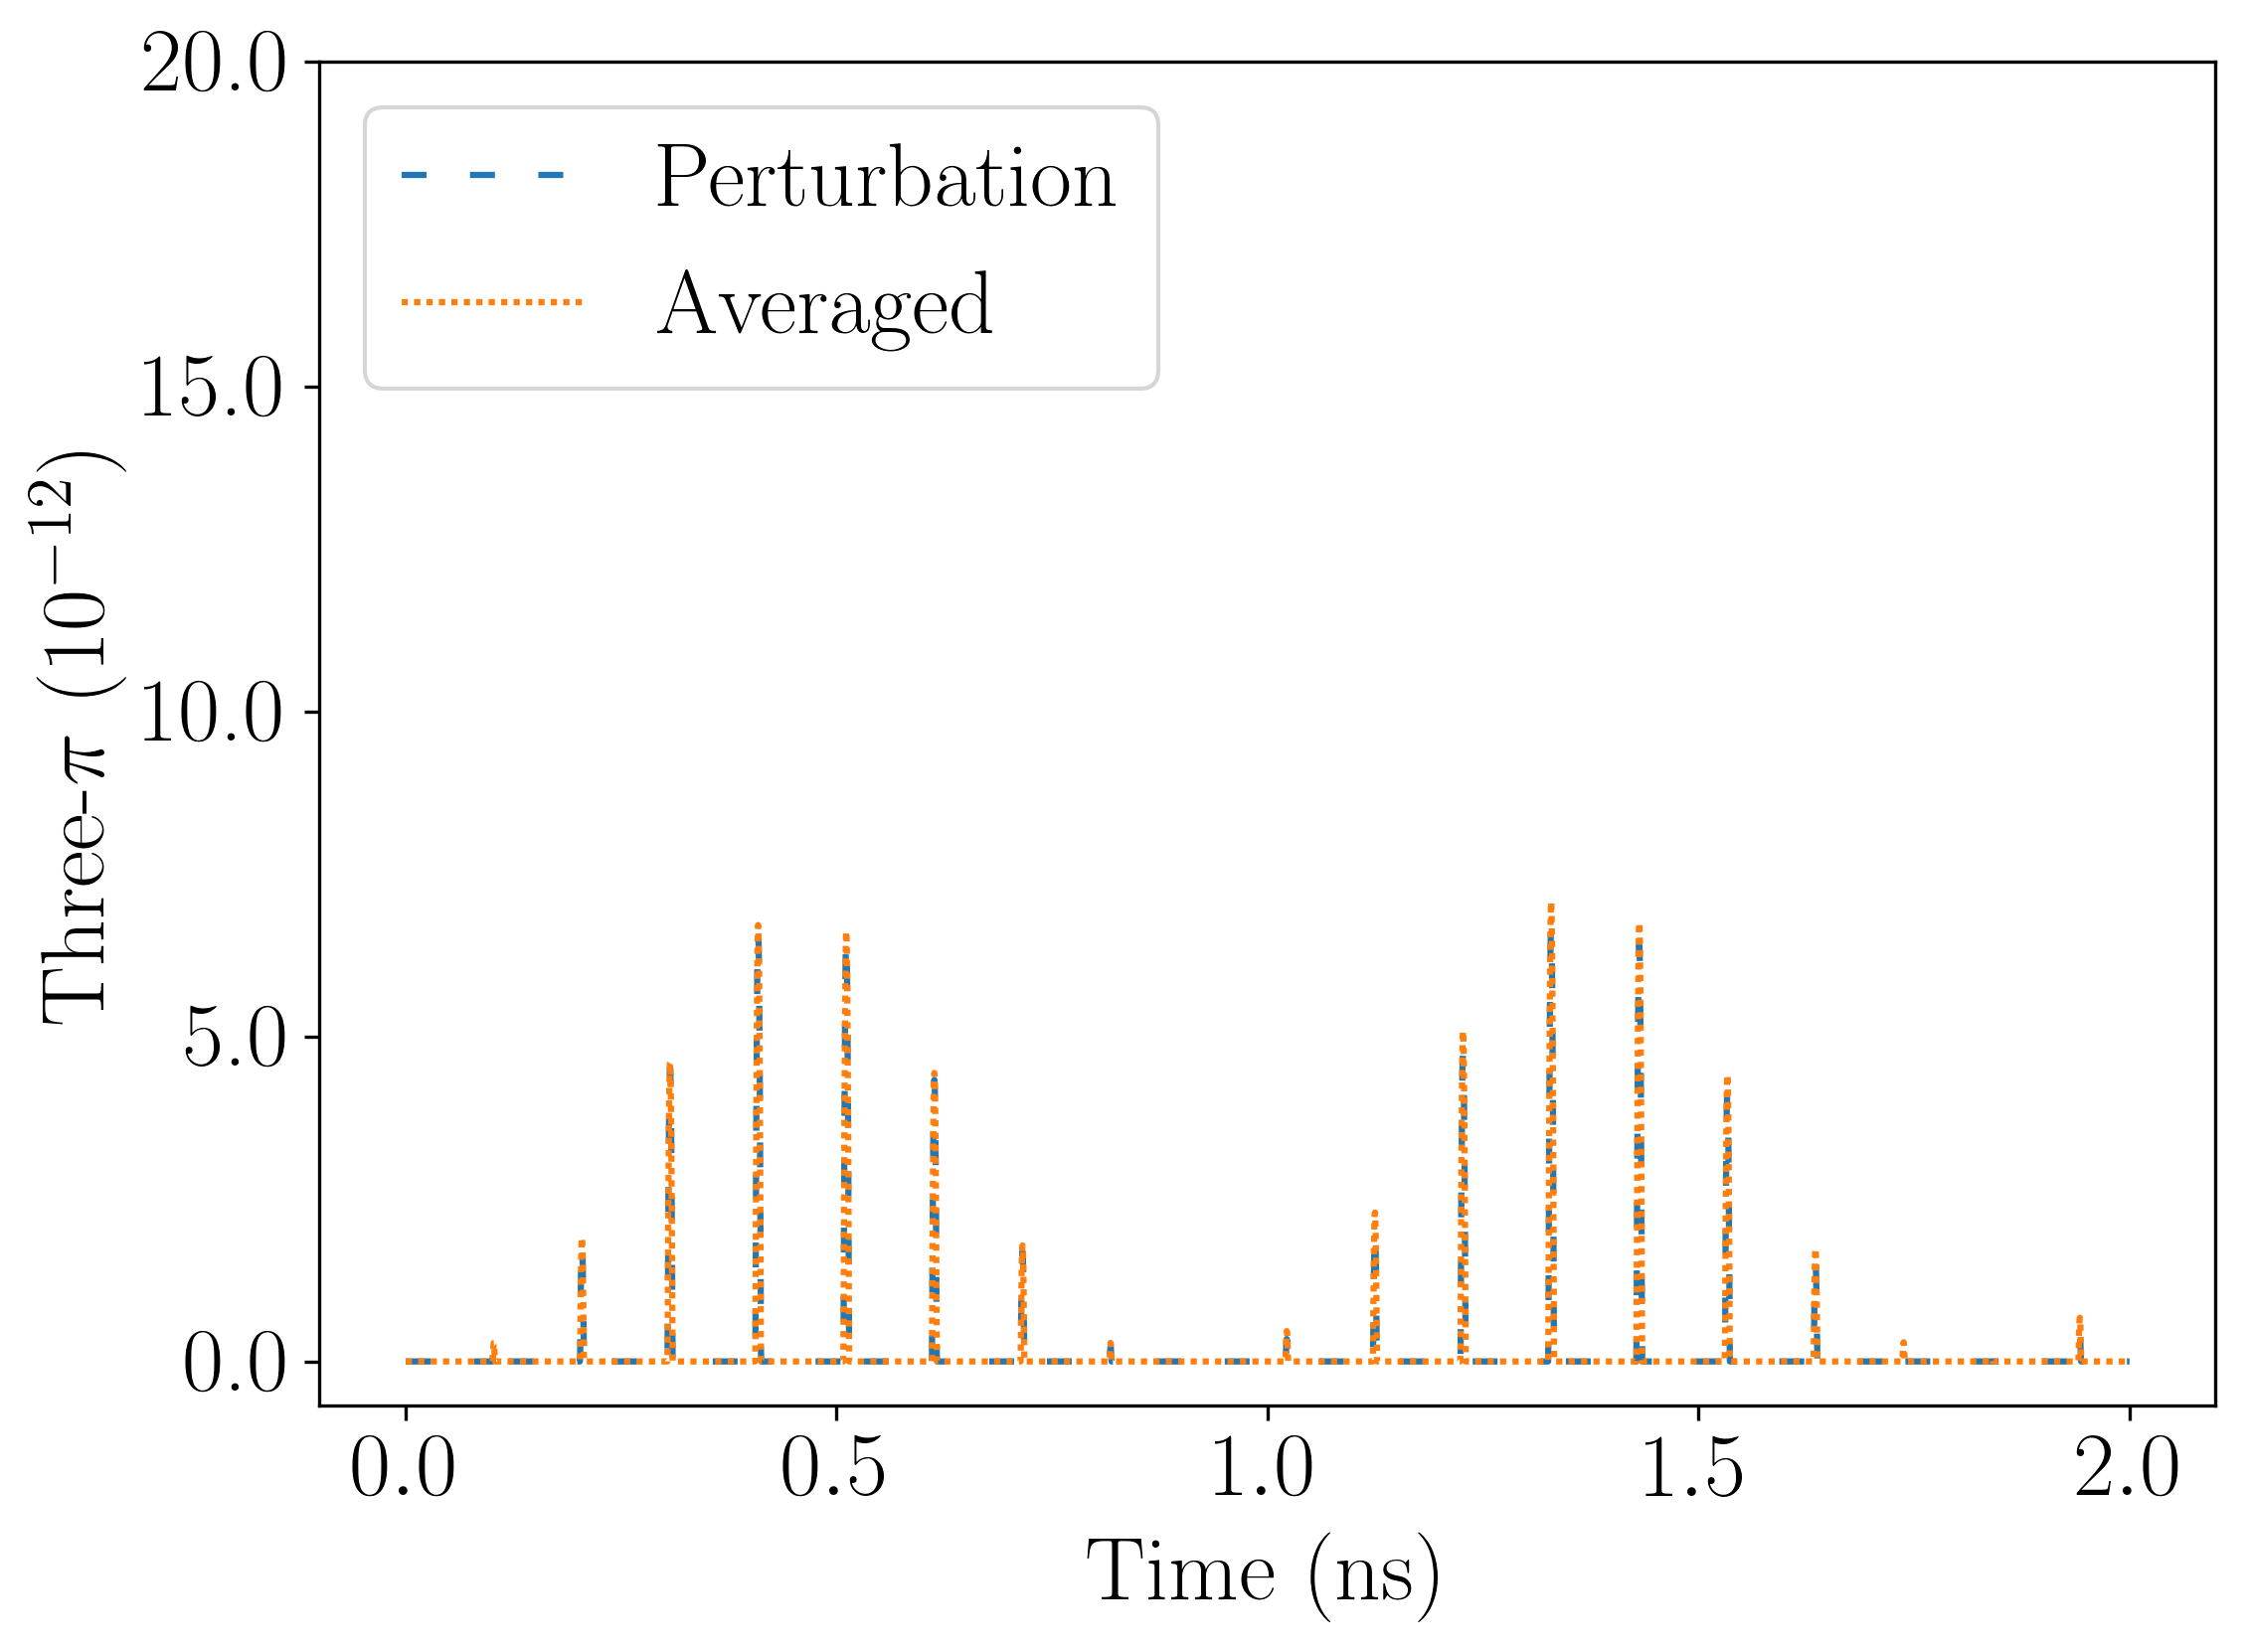

In [149]:
import matplotlib

#changes font size
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'figure.autolayout': True})
# matplotlib.rcParams['mathtext.rm'] = 'Arial'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')



n = np.load('data/neg_avg_3q_num_an.npy')
t = np.load('data/tpi_avg_3q_num_an.npy')
n_2 = np.load('data/neg_dyn_3q_num_an.npy')
t_2 = np.load('data/tpi_dyn_3q_num_an.npy')
n_an = np.load('data/neg_ana_3q_num_an.npy')
t_an = np.load('data/tpi_ana_3q_num_an.npy')


#compare numerical and analytical negativity
plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot(t_list*10**9,n_an*10**4,dashes=[4, 7], label = r' Perturbation')
plt.plot(t_list*10**9,n*10**4,dashes=[1, 1], label = r' Averaged')
# plt.plot(t_list*10**9,n_2*10**4, label = r' Switching')
plt.legend()
plt.xlabel(r' Time (ns)', fontsize = 22)
plt.ylabel(r' Negativity ($10^{-4}$)', fontsize = 22)
plt.legend(loc=2)
ymin = -0.1*max(n_2*10**4)
ymax = max(n_2*10**4)+1.5*max(n_2*10**4)
plt.ylim((ymin,ymax))

locs, labels = plt.yticks()
labels = [str(round(e,2)) for e in locs if e >= 0]#locs
locs = [e for e in locs if e>=0]
plt.yticks(locs, labels)

plt.savefig('negativity_3q_num_an.eps', dpi = 300)
plt.show()



#compare numerical and analytical three-pi
plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot(t_list*10**9,t_an*10**12,dashes=[4, 7], label = 'Perturbation')
plt.plot(t_list*10**9,t*10**12,dashes=[1, 1], label = 'Averaged')
# plt.plot(t_list*10**9,t_2*10**12, label = 'Switching')
plt.legend()
plt.xlabel(r' Time (ns)', fontsize = 22)
plt.ylabel(r' Three-$\pi$ ($10^{-12}$)', fontsize = 22)
plt.legend(loc=2)
ymin = -0.1*max(t_2*10**12)
ymax = max(t_2*10**12)+1.5*max(t_2*10**12)
plt.ylim((ymin,ymax))

locs, labels = plt.yticks()
labels = [str(round(e,2)) for e in locs if e >= 0]#locs
locs = [e for e in locs if e>=0]
plt.yticks(locs, labels)


plt.savefig('three_pi_3q_num_an.eps', dpi = 300)
plt.show()




# plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
# plt.plot(tau_list*10**12, c_an*10**6,dashes=[4, 7], label = 'Perturbation')
# plt.plot(tau_list*10**12, c*10**6,dashes=[1, 1], label = 'Averaged')
# plt.plot(tau_list*10**12, c_2*10**6, label = 'Numerical')
# plt.xlabel(r' Time (ps)', fontsize = 28)
# plt.ylabel(r' Concurrence ($10^{-6}$)', fontsize = 28)
# # plt.ylabel(r' Concurrence')
# plt.legend(loc=2)
# ymin = -0.1*max(conc_2*10**6)
# ymax = max(conc_2*10**6)+1.5*max(conc_2*10**6)
# plt.ylim((ymin,ymax)) # sets limit for y-axis

# locs, labels = plt.yticks()
# labels = [str(round(e,2)) for e in locs if e >= 0]#locs
# locs = [e for e in locs if e>=0]
# plt.yticks(locs, labels)

# plt.savefig('concurrence_2q_num_an.eps', dpi = 300)
# plt.show()

    

In [141]:
2*10**-9/5000

4e-13

In [126]:
np.pi/(20*wa)

4.59643316786174e-12